## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-03-02 18:14:27--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  11.9MB/s    in 0.5s    

2025-03-02 18:14:28 (11.9 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any

In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
df.shape

(1000209, 4)

In [5]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()
df.shape

(994852, 4)

In [6]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [7]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [8]:
df_test.head()

,user_id,item_id,rating,datetime
100406,670,1248,4,2000-12-01 00:02:42
100407,670,1249,4,2000-12-01 00:03:23
100408,670,3932,3,2000-12-01 00:03:23
100410,670,1250,4,2000-12-01 00:02:42
100413,670,1259,4,2000-12-01 00:03:23


<Axes: >

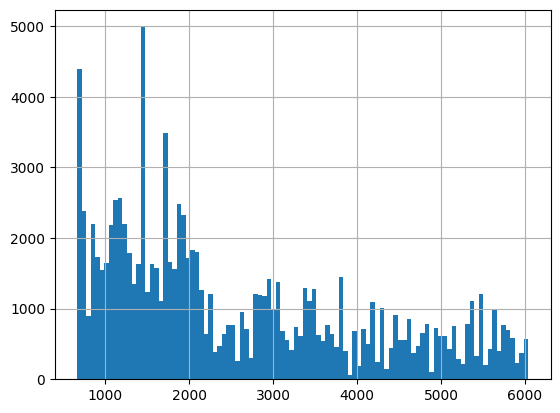

In [9]:
df_test.user_id.hist(bins=100)

In [10]:
df_test[df_test.user_id < 1000].shape

(13307, 4)

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106471 entries, 100406 to 1000172
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   106471 non-null  int64         
 1   item_id   106471 non-null  int64         
 2   rating    106471 non-null  int64         
 3   datetime  106471 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 4.1 MB


In [12]:
df_test.user_id.value_counts()

,count
user_id,
1088,1048
1448,1015
1447,981
678,930
4169,757
...,...
4674,1
1336,1
1048,1


In [13]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [14]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

In [15]:
df_test[df_test.user_id < 1000].shape

(39611, 4)

<Axes: >

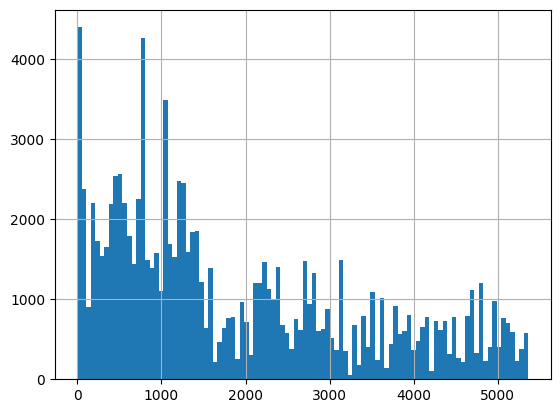

In [16]:
df_test.user_id.hist(bins=100)

In [17]:
df_train.head()

,user_id,item_id,rating,datetime
100409,0,2994,3,2000-11-30 23:49:23
100411,0,929,4,2000-11-30 23:52:33
100412,0,567,4,2000-11-30 23:51:54
100415,0,3005,1,2000-11-30 23:58:06
100416,0,3006,4,2000-11-30 23:57:50


In [18]:
df_train.shape, df_test.shape

((787420, 4), (106471, 4))

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [19]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1
    result = np.zeros((n_users, n_items))
    for _, row in df.iterrows():
        result[int(row['user_id']), int(row['item_id'])] = row['rating']
    return result #shape ~ [n_users, n_items]

In [20]:
interactions = df_to_matrix(df_train)

In [21]:
interactions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [22]:
interactions.shape

(5365, 3010)

In [23]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:
    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1
    rows = df['user_id'].values.astype(int)
    cols = df['item_id'].values.astype(int)
    data = df['rating'].values
    result = coo_array((data, (rows, cols)), shape=(n_users, n_items))
    return result # coo_array

In [24]:
coo_interactions = df_to_coo(df_train)

In [25]:
coo_interactions

<5365x3010 sparse array of type '<class 'numpy.int64'>'
	with 787420 stored elements in COOrdinate format>

In [26]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [27]:
from scipy.sparse.linalg import svds

In [28]:
def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)

    if isinstance(interractions, np.ndarray):
        U, S, V = np.linalg.svd(interractions, full_matrices=False)

        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = S[:n_singular_values]
            V = V[:n_singular_values, :]

    else:
        interractions = interractions.astype(float)
        if n_singular_values == -1:
            n_singular_values = min(interractions.shape) - 1

        U, S, V = svds(interractions, k=n_singular_values)
        U = U[:, ::-1]
        S = S[::-1]
        V = V[::-1, :]

    S = np.diag(S)

    return U, S, V

In [29]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [30]:
U.shape, S.shape, V.shape

((5365, 3010), (3010, 3010), (3010, 3010))

In [31]:
interactions.shape

(5365, 3010)

In [32]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [33]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    if isinstance(interractions, np.ndarray):
        dense = interractions.copy()
    else:
        dense = interractions.toarray()
    U, S, V = make_svd(interractions, n_singular_values)
    pred = U @ S @ V
    pred[dense != 0] = -float("inf")
    recommendations = pred.argsort(axis=1)[:, ::-1][:, :top_k]

    return recommendations #shape ~ [n_users, top_k]

In [34]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [35]:
import time
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

def ndcg_metric(gt_items, predicted):
    at = len(predicted)
    relevance = np.array([1 if x in gt_items else 0 for x in predicted])
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])
    if ideal_dcg == 0.0:
        return 0.0
    return rank_dcg / ideal_dcg

def dcg(scores):
    return np.sum((2 ** scores - 1) / np.log2(np.arange(scores.shape[0]) + 2), dtype=np.float64)

def compute_ndcg(recs: np.ndarray, test_interactions: coo_array, top_k: int) -> float:
    test_csr = test_interactions.tocsr()
    n_users = recs.shape[0]
    total_ndcg = 0.0
    user_count = 0

    for u in range(n_users):
        row_arr = test_csr[u:u+1, :].toarray().ravel()
        gt_items = set(np.where(row_arr > 0)[0])
        if not gt_items:
            continue
        predicted = recs[u][:top_k]
        ndcg_val = ndcg_metric(gt_items, predicted)
        total_ndcg += ndcg_val
        user_count += 1

    return total_ndcg / user_count if user_count > 0 else 0.0

def plot_graphs(interactions: Union[np.ndarray, coo_array], test_interactions: coo_array, top_k: int = 100):
    nsv_list = [1, 10, 50, 200, 1000]
    ndcg_scores = []
    times = []

    for n_singular_values in nsv_list:
        start_time = time.time()
        recs = make_svd_recommendations(interactions, n_singular_values=n_singular_values, top_k=top_k)
        elapsed = time.time() - start_time
        times.append(elapsed)
        ndcg_val = compute_ndcg(recs, test_interactions, top_k)
        ndcg_scores.append(ndcg_val)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(nsv_list, ndcg_scores, marker='o')
    plt.xlabel('n_singular_values')
    plt.ylabel('NDCG')
    plt.title('NDCG vs n_singular_values')

    plt.subplot(1, 2, 2)
    plt.plot(nsv_list, times, marker='o')
    plt.xlabel('n_singular_values')
    plt.ylabel('Time (s)')
    plt.title('Time vs n_singular_values (sparse matrix)')

    plt.tight_layout()
    plt.show()

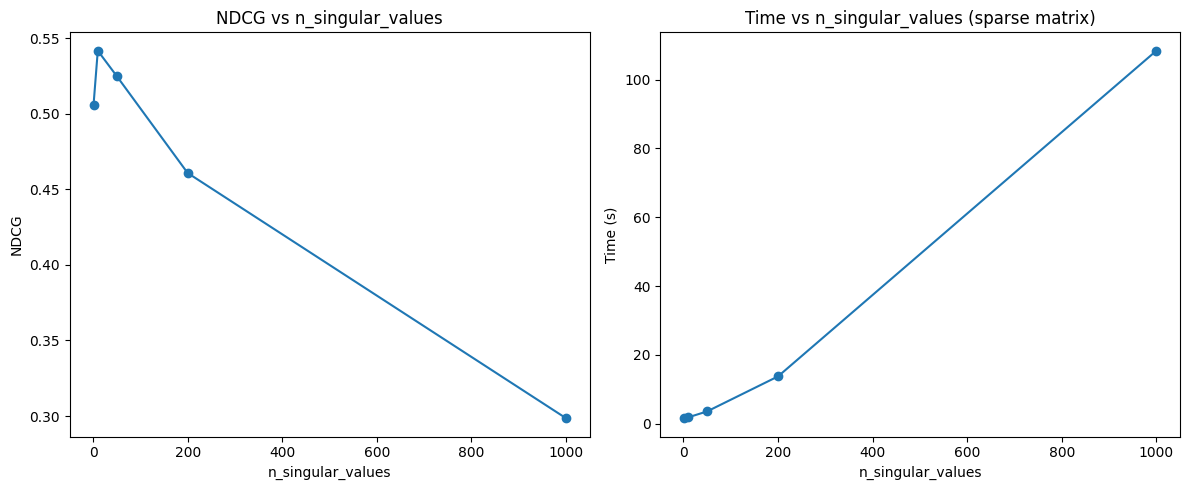

In [36]:
test_coo_interactions = df_to_coo(df_test)
plot_graphs(coo_interactions, test_coo_interactions, top_k=100)

Время вычисления от n_singular_values растет линейно и монотонно, а вот NDCG метрика максимальна при значении n_singular_values равным 10, что может значить, что именно в них заложена основная информация о предпочтениях пользователей, а добавление дополнительных значений вносит больше шума, чем полезной информации.

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [37]:
pip install implicit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 39.0 MB/s eta 0:00:00


In [38]:
import numpy as np
from typing import Union
from scipy.sparse import coo_array, coo_matrix
from implicit.als import AlternatingLeastSquares

def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array],
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01
):
    if isinstance(interactions, np.ndarray):
        interactions = coo_matrix(interactions)

    train_matrix = (interactions * alpha).astype(np.float32).tocsr()

    als_model = AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        iterations=15
    )
    als_model.fit(train_matrix)

    num_users = train_matrix.shape[0]
    user_indices = np.arange(num_users)
    recommendations = np.zeros((num_users, top_k), dtype=np.int32)

    for idx, user in enumerate(user_indices):
        rec_items, _ = als_model.recommend(user, train_matrix.getrow(user), N=top_k, filter_already_liked_items=True)
        recommendations[idx, :len(rec_items)] = rec_items

    return recommendations #shape ~ [n_users, top_k]

In [39]:
recs = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [40]:
pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.7 MB/s eta 0:00:00


In [41]:
import optuna

def objective(trial):
    n_factors = trial.suggest_categorical("n_factors", [10, 50, 100, 200, 300])
    alpha = trial.suggest_categorical("alpha", [1.0, 10.0, 20.0, 50.0])
    regularization = trial.suggest_categorical("regularization", [0.001, 0.01, 0.1, 1.0])

    recs = make_als_recommendations(
        interactions,
        top_k=100,
        n_factors=n_factors,
        alpha=alpha,
        regularization=regularization
    )

    return compute_ndcg(recs, test_coo_interactions, top_k=100)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Лучшие параметры:", study.best_params)
print("Максимальное NDCG:", study.best_value)

[I 2025-03-02 18:20:51,248] A new study created in memory with name: no-name-6c5a1035-458a-46e3-afb4-7f32114302dd


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:21:16,085] Trial 0 finished with value: 0.41449904248609654 and parameters: {'n_factors': 50, 'alpha': 50.0, 'regularization': 0.1}. Best is trial 0 with value: 0.41449904248609654.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:21:25,133] Trial 1 finished with value: 0.5346044502913658 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 1 with value: 0.5346044502913658.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:22:17,598] Trial 2 finished with value: 0.4313932576699759 and parameters: {'n_factors': 300, 'alpha': 50.0, 'regularization': 0.001}. Best is trial 1 with value: 0.5346044502913658.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:23:01,696] Trial 3 finished with value: 0.4434758483461929 and parameters: {'n_factors': 200, 'alpha': 20.0, 'regularization': 0.001}. Best is trial 1 with value: 0.5346044502913658.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:23:13,974] Trial 4 finished with value: 0.4433973394416832 and parameters: {'n_factors': 50, 'alpha': 20.0, 'regularization': 0.001}. Best is trial 1 with value: 0.5346044502913658.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:23:26,436] Trial 5 finished with value: 0.44546861495178147 and parameters: {'n_factors': 50, 'alpha': 20.0, 'regularization': 0.01}. Best is trial 1 with value: 0.5346044502913658.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:24:13,526] Trial 6 finished with value: 0.4477258233180025 and parameters: {'n_factors': 300, 'alpha': 1.0, 'regularization': 0.01}. Best is trial 1 with value: 0.5346044502913658.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:24:25,313] Trial 7 finished with value: 0.4463004514650083 and parameters: {'n_factors': 50, 'alpha': 20.0, 'regularization': 0.01}. Best is trial 1 with value: 0.5346044502913658.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:25:03,287] Trial 8 finished with value: 0.44997099036018917 and parameters: {'n_factors': 200, 'alpha': 20.0, 'regularization': 0.01}. Best is trial 1 with value: 0.5346044502913658.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:25:40,232] Trial 9 finished with value: 0.45670087232632484 and parameters: {'n_factors': 200, 'alpha': 10.0, 'regularization': 1.0}. Best is trial 1 with value: 0.5346044502913658.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:25:46,860] Trial 10 finished with value: 0.5351361707268436 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 10 with value: 0.5351361707268436.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:25:54,813] Trial 11 finished with value: 0.5344396966273572 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 10 with value: 0.5351361707268436.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:26:01,554] Trial 12 finished with value: 0.5346901246500083 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 10 with value: 0.5351361707268436.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:26:12,202] Trial 13 finished with value: 0.5029670868383534 and parameters: {'n_factors': 100, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 10 with value: 0.5351361707268436.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:26:20,397] Trial 14 finished with value: 0.5348217622113628 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 10 with value: 0.5351361707268436.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:26:27,143] Trial 15 finished with value: 0.49878089647389545 and parameters: {'n_factors': 10, 'alpha': 10.0, 'regularization': 0.1}. Best is trial 10 with value: 0.5351361707268436.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:26:34,964] Trial 16 finished with value: 0.5346615989516921 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 10 with value: 0.5351361707268436.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:26:46,125] Trial 17 finished with value: 0.5027033807723498 and parameters: {'n_factors': 100, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 10 with value: 0.5351361707268436.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:26:52,841] Trial 18 finished with value: 0.5358058094818723 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 18 with value: 0.5358058094818723.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:27:00,762] Trial 19 finished with value: 0.42681163003725425 and parameters: {'n_factors': 10, 'alpha': 50.0, 'regularization': 0.1}. Best is trial 18 with value: 0.5358058094818723.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:27:07,536] Trial 20 finished with value: 0.5030857032067998 and parameters: {'n_factors': 10, 'alpha': 10.0, 'regularization': 1.0}. Best is trial 18 with value: 0.5358058094818723.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:27:15,374] Trial 21 finished with value: 0.5331194774664899 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 18 with value: 0.5358058094818723.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:27:22,332] Trial 22 finished with value: 0.5345431996864491 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 18 with value: 0.5358058094818723.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:27:29,898] Trial 23 finished with value: 0.5339947853384477 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 18 with value: 0.5358058094818723.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:27:38,320] Trial 24 finished with value: 0.5353097686048086 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 18 with value: 0.5358058094818723.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:27:50,168] Trial 25 finished with value: 0.5010658323251563 and parameters: {'n_factors': 100, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 18 with value: 0.5358058094818723.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:28:37,970] Trial 26 finished with value: 0.44698946001206374 and parameters: {'n_factors': 300, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 18 with value: 0.5358058094818723.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:28:45,940] Trial 27 finished with value: 0.5336962087682114 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.1}. Best is trial 18 with value: 0.5358058094818723.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:28:52,715] Trial 28 finished with value: 0.4291846730927326 and parameters: {'n_factors': 10, 'alpha': 50.0, 'regularization': 0.001}. Best is trial 18 with value: 0.5358058094818723.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:29:00,631] Trial 29 finished with value: 0.5034242590865389 and parameters: {'n_factors': 10, 'alpha': 10.0, 'regularization': 0.1}. Best is trial 18 with value: 0.5358058094818723.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:29:39,303] Trial 30 finished with value: 0.44937762388764246 and parameters: {'n_factors': 200, 'alpha': 50.0, 'regularization': 1.0}. Best is trial 18 with value: 0.5358058094818723.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:29:46,093] Trial 31 finished with value: 0.5341137004628328 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 18 with value: 0.5358058094818723.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:29:53,948] Trial 32 finished with value: 0.5406868060266626 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:30:01,406] Trial 33 finished with value: 0.5346816050906069 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:30:08,727] Trial 34 finished with value: 0.5331988730449173 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:31:00,423] Trial 35 finished with value: 0.44009412886177435 and parameters: {'n_factors': 300, 'alpha': 1.0, 'regularization': 0.001}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:31:12,275] Trial 36 finished with value: 0.5166136213399194 and parameters: {'n_factors': 50, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:31:19,252] Trial 37 finished with value: 0.42750150539361 and parameters: {'n_factors': 10, 'alpha': 50.0, 'regularization': 0.001}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:31:29,432] Trial 38 finished with value: 0.5029979966077917 and parameters: {'n_factors': 100, 'alpha': 1.0, 'regularization': 0.01}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:31:41,250] Trial 39 finished with value: 0.4483564456622819 and parameters: {'n_factors': 50, 'alpha': 20.0, 'regularization': 1.0}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:32:31,577] Trial 40 finished with value: 0.44730087758098225 and parameters: {'n_factors': 300, 'alpha': 1.0, 'regularization': 0.01}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:32:39,096] Trial 41 finished with value: 0.5344690231906405 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:32:46,245] Trial 42 finished with value: 0.5337448488898118 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:32:54,569] Trial 43 finished with value: 0.53454532654468 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:33:32,105] Trial 44 finished with value: 0.4529070082317799 and parameters: {'n_factors': 200, 'alpha': 20.0, 'regularization': 1.0}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:33:38,836] Trial 45 finished with value: 0.5341120294226904 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:33:46,962] Trial 46 finished with value: 0.5024200110629521 and parameters: {'n_factors': 10, 'alpha': 10.0, 'regularization': 1.0}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:33:59,277] Trial 47 finished with value: 0.5149948319237093 and parameters: {'n_factors': 50, 'alpha': 1.0, 'regularization': 0.001}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:34:06,002] Trial 48 finished with value: 0.5366843458684111 and parameters: {'n_factors': 10, 'alpha': 1.0, 'regularization': 0.01}. Best is trial 32 with value: 0.5406868060266626.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:34:43,832] Trial 49 finished with value: 0.4476038168000049 and parameters: {'n_factors': 200, 'alpha': 20.0, 'regularization': 0.01}. Best is trial 32 with value: 0.5406868060266626.


Лучшие параметры: {'n_factors': 10, 'alpha': 1.0, 'regularization': 1.0}
Максимальное NDCG: 0.5406868060266626


svd получился почти такой же как и лучший als по метрике ndcg. Интересно.

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [42]:
# Чуть модернизируем одну из наших функций перед тем как начать
def df_to_coo(df: pd.DataFrame) -> coo_matrix:
    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1
    rows = df['user_id'].values.astype(int)
    cols = df['item_id'].values.astype(int)
    data = df['rating'].values
    result = coo_matrix((data, (rows, cols)), shape=(n_users, n_items))
    return result

# 1. Бинаризация всех интеракций: все оценки - 1
df_train_bin = df_train.copy()
df_train_bin['rating'] = 1

# 2. Бинаризация только для оценок 4 и 5: >=4 - 1, иначе 0
df_train_45 = df_train.copy()
df_train_45['rating'] = (df_train_45['rating'] >= 4).astype(int)

# 3. Оценки 4 и 5 - 1, ниже 4 - -1
df_train_45_neg = df_train.copy()
df_train_45_neg['rating'] = df_train_45_neg['rating'].apply(lambda r: 1 if r >= 4 else -1)

# 4. Оценки 4 и 5 - 1, ниже 4 - -1 с учетом времени (сглаживание)
df_train_45_neg_time = df_train.copy()
df_train_45_neg_time['rating'] = df_train_45_neg_time['rating'].apply(lambda r: 1 if r >= 4 else -1)
max_date = df_train_45_neg_time['datetime'].max()

df_train_45_neg_time['days_diff'] = (max_date - df_train_45_neg_time['datetime']).dt.days
df_train_45_neg_time['rating'] = df_train_45_neg_time['rating'] * np.exp(-df_train_45_neg_time['days_diff'] / 30)

matrices = {
    "Бинаризация всех интеракций": df_to_coo(df_train_bin),
    "Оценки >=4: 1, иначе 0": df_to_coo(df_train_45),
    "Оценки >=4: 1, иначе -1": df_to_coo(df_train_45_neg),
    "Оценки >=4 с временным сглаживанием": df_to_coo(df_train_45_neg_time)
}

test_coo = df_to_coo(df_test)
results = {}

for variant, matrix in matrices.items():
    print(f"\nОбработка варианта: {variant}")

    dense_matrix = matrix.toarray()
    recs_svd = make_svd_recommendations(dense_matrix, n_singular_values=-1, top_k=100)
    ndcg_svd = compute_ndcg(recs_svd, test_coo, top_k=100)

    recs_als = make_als_recommendations(matrix, top_k=100, n_factors=100, alpha=1.0, regularization=0.01)
    ndcg_als = compute_ndcg(recs_als, test_coo, top_k=100)

    results[variant] = {"NDCG SVD": ndcg_svd, "NDCG ALS": ndcg_als}
    print(f"  SVD NDCG: {ndcg_svd:.4f}")
    print(f"  ALS NDCG: {ndcg_als:.4f}")

print("\nСводные результаты:")
for variant, metrics in results.items():
    print(f"{variant}: SVD NDCG = {metrics['NDCG SVD']:.4f}, ALS NDCG = {metrics['NDCG ALS']:.4f}")


Обработка варианта: Бинаризация всех интеракций


  0%|          | 0/15 [00:00<?, ?it/s]

  SVD NDCG: 0.3781
  ALS NDCG: 0.4969

Обработка варианта: Оценки >=4: 1, иначе 0


  0%|          | 0/15 [00:00<?, ?it/s]

  SVD NDCG: 0.3417
  ALS NDCG: 0.4974

Обработка варианта: Оценки >=4: 1, иначе -1


  0%|          | 0/15 [00:00<?, ?it/s]

  SVD NDCG: 0.3137
  ALS NDCG: 0.5024

Обработка варианта: Оценки >=4 с временным сглаживанием


  0%|          | 0/15 [00:00<?, ?it/s]

  SVD NDCG: 0.3167
  ALS NDCG: 0.5130

Сводные результаты:
Бинаризация всех интеракций: SVD NDCG = 0.3781, ALS NDCG = 0.4969
Оценки >=4: 1, иначе 0: SVD NDCG = 0.3417, ALS NDCG = 0.4974
Оценки >=4: 1, иначе -1: SVD NDCG = 0.3137, ALS NDCG = 0.5024
Оценки >=4 с временным сглаживанием: SVD NDCG = 0.3167, ALS NDCG = 0.5130


Способ 4 сработал лучше всех!

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [43]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef: float = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.user_factors = None
        self.item_factors = None
        self.train_mask = None

    def fit(self, interactions: np.ndarray, n_iterations: int = 10):
        n_users, n_items = interactions.shape
        self.train_mask = interactions > 0
        p = (interactions > 0).astype(np.float64)
        c = 1 + self.alpha * interactions

        np.random.seed(0)
        X = np.random.normal(scale=0.01, size=(n_users, self.n_factors))
        Y = np.random.normal(scale=0.01, size=(n_items, self.n_factors))
        lambda_I = self.reg_coef * np.eye(self.n_factors)

        for it in range(n_iterations):
            YTY = Y.T @ Y
            for u in range(n_users):
                idx = np.where(self.train_mask[u])[0]
                if len(idx) == 0:
                    continue
                Cu_minus_I = c[u, idx] - 1

                A = YTY.copy()
                for i, w in zip(idx, Cu_minus_I):
                    A += w * np.outer(Y[i], Y[i])
                A += lambda_I
                b = np.zeros(self.n_factors)
                for i in idx:
                    b += c[u, i] * Y[i]
                X[u] = np.linalg.solve(A, b)

            XTX = X.T @ X
            for i in range(n_items):
                idx = np.where(self.train_mask[:, i])[0]
                if len(idx) == 0:
                    continue
                Ci_minus_I = c[idx, i] - 1
                A = XTX.copy()
                for u, w in zip(idx, Ci_minus_I):
                    A += w * np.outer(X[u], X[u])
                A += lambda_I
                b = np.zeros(self.n_factors)
                for u in idx:
                    b += c[u, i] * X[u]
                Y[i] = np.linalg.solve(A, b)

            print(f"Iteration {it + 1}/{n_iterations} completed.")

        self.user_factors = X
        self.item_factors = Y

    def predict(self, top_k: int = 100):
        scores = self.user_factors @ self.item_factors.T
        scores[self.train_mask] = -np.inf

        n_users = scores.shape[0]
        predicts = np.zeros((n_users, top_k), dtype=np.int32)
        for u in range(n_users):
            top_indices = np.argpartition(scores[u], -top_k)[-top_k:]
            top_indices = top_indices[np.argsort(scores[u][top_indices])[::-1]]
            predicts[u] = top_indices
        return predicts # shape ~ [n_users, top_k]

In [46]:
print("Обучение iALS (на NumPy)...")
ials_model = iALS(n_factors=100, alpha=1.0, reg_coef=0.01)
ials_model.fit(interactions, n_iterations=10)
preds_ials = ials_model.predict(top_k=100)
ndcg_ials = compute_ndcg(preds_ials, test_coo, top_k=100)
print(f"iALS (NumPy) NDCG: {ndcg_ials:.4f}")

print("\nОбучение implicit ALS...")
recs_implicit = make_als_recommendations(
    interactions, top_k=100, n_factors=100, alpha=1.0, regularization=0.01
)
ndcg_implicit = compute_ndcg(recs_implicit, test_coo, top_k=100)
print(f"implicit ALS NDCG: {ndcg_implicit:.4f}")

Обучение iALS (на NumPy)...
Iteration 1/10 completed.
Iteration 2/10 completed.
Iteration 3/10 completed.
Iteration 4/10 completed.
Iteration 5/10 completed.
Iteration 6/10 completed.
Iteration 7/10 completed.
Iteration 8/10 completed.
Iteration 9/10 completed.
Iteration 10/10 completed.
iALS (NumPy) NDCG: 0.5020

Обучение implicit ALS...


  0%|          | 0/15 [00:00<?, ?it/s]

implicit ALS NDCG: 0.5026


Метрики сравнимы. Как и говорилось в задании. Хорошо.